### Load Images

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_hub as hub

# Helper libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import cv2

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")



TF version: 2.10.1
Hub version: 0.15.0
GPU is available


#### Constant Variables

In [2]:
# Pfad zum Hauptordner, der die Unterordner mit Bildern enthält
main_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train"
train_val_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train"
test_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\test"

augmented_images_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\augmented_images"

# Auflösung der Bilder in das Format für das neuronale Netz
desired_height = 128
desired_width = 128


#### Data Augmentation Pipeline

In [3]:
# Erstellen eines ImageDataGenerator für Data Augmentation
train_datagen = ImageDataGenerator(
    #rescale=1./255,   # Normalisieren der Bilder
    #rotation_range=20,  # Zufällige Rotation der Bilder
    #width_shift_range=0.1,  # Horizontaler Shift
    brightness_range = [0.5, 1.1],
    #height_shift_range=0.1, # Vertikaler Shift
    shear_range=0.1,        # Scherung
    zoom_range=[0.2, 1],         # Zoom
    fill_mode='nearest',     # Füllmethode für neue Pixel
)

With this definition the ImageDataGenerator object, when used, will modify existing images to create new ones by applying the following modifications: 
- Rotation: Randomly rotates the images within the range of -20 to +20 degrees.
- Shear: Applies random shearing transformations to the images with a shear intensity of 0.2.
- Zoom: Randomly zooms in or out of the images with a zoom range of 0.2.
- Width Shift: Shifts the width of the images horizontally by a fraction of the total width, with a maximum shift of 0.1.
- Height Shift: Shifts the height of the images vertically by a fraction of the total height, with a maximum shift of 0.1.
- Horizontal Flip: Randomly flips the images horizontally.
- Vertical Flip: Does not perform vertical flipping on the images.
- Fill Mode: Determines how to fill the pixels that may be created due to the above transformations. The 'nearest' mode fills the empty pixels with the nearest pixel value.

(information retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

#### Augmentation of the images and save them into folder

In [6]:
NO_AUGMENTED_IMAGES = 5     # create 2 augmented images per original image

total_n_augmented_imgs = 0
augmenting_desired = False

if augmenting_desired:  # erst Testdatensatz erstellen, dann augmentieren

    # Durchlaufen Sie alle Unterordner
    for folder in os.listdir(train_val_data_folder):
        folder_path = os.path.join(train_val_data_folder, folder)
        if os.path.isdir(folder_path):
            # Load the image and add a batch dimension --> "data_generator.flow()" expects a batch of images as input
            output_folder_path = os.path.join(augmented_images_data_folder, folder)
            if not os.path.exists(output_folder_path):
                os.makedirs(output_folder_path)

            print(f"Augmenting images from: {folder_path}")
            for file in os.listdir(folder_path):
                if file.endswith(".jpg"):
                    path = os.path.join(folder_path, file)
                    img = cv2.imread(path)
                    img = img.reshape((1,) + img.shape)

                    # Generieren Sie die augmentierten Bilder
                    augmented_images = train_datagen.flow(img, batch_size=1)

                    # Speichern Sie die augmentierten Bilder
                    for i in range(NO_AUGMENTED_IMAGES):
                        augmented_image = next(augmented_images)
                        file_name = file.split(".jpg")[0] + '_aug_' + str(i) + '.jpg'
                        output_path = os.path.join(output_folder_path, file_name)
                        cv2.imwrite(output_path, augmented_image[0])
                        total_n_augmented_imgs += 1

    print(f"Total number of augmented images created: {total_n_augmented_imgs}")

Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\end_speed
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\no_sign
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\no_speed_sign
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_100
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_120
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\train\speed_30
Augmenting images from: C:\Users\aaron\Desktop\Programmierung\M

#### Load images with tf.flow_from_directory() to directly create corresponding labels 

In [7]:
batch_size = 64

if False:
    color_mode = "grayscale"
    input_channels = 1
else:
    color_mode = "rgb"
    input_channels = 3


# Laden der Bilder und Labels aus den Unterordnern
print("Training dataset:")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_images_data_folder,
    color_mode=color_mode,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nValidation dataset:")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_images_data_folder,
    color_mode=color_mode,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nTest dataset:")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_folder,
    color_mode=color_mode,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)


class_names = train_dataset.class_names
number_of_classes = len(train_dataset.class_names)

print(f"Klassen: {class_names}")
print(f"Anzahl der Klassen: {number_of_classes}")

Training dataset:
Found 24955 files belonging to 10 classes.
Using 19964 files for training.

Validation dataset:
Found 24955 files belonging to 10 classes.
Using 4991 files for validation.

Test dataset:
Found 14965 files belonging to 10 classes.
Klassen: ['end_speed', 'no_sign', 'no_speed_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
Anzahl der Klassen: 10


#### Helper Functions

In [8]:
def create_checkpoint(model_name):
    # Define the checkpoint callback
    filepath = 'models/' + str(model_name) + '.h5'
    return ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy',  # Metric to monitor for saving the weights
        save_best_only=True,  # Save only the best model
        mode='max',  # Higher value is considered better for the monitored metric
        verbose=1
    )


def create_early_stopping(patience):
    return EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor for early stopping
        patience=patience,  # Number of epochs with no improvement before stopping
        verbose=1
    )


def evaluate_model(history, model_object, model_name, training_time, test_ds):
    """
    Evaluate a trained model using the provided history, model object, and test dataset.
    Parameters:
        history (tf.keras.callbacks.History): History object containing the training history.
        model_object (tf.keras.Model): The trained model object.
        model_name (str): The name of the model used for loading the weights.
        training_time (float): The time taken for training the model.
        test_ds (tf.data.Dataset): The test dataset for evaluation.

    Returns:
        None

    Example:
        evaluate_model(history, model_object, "model_1", 123.45, test_ds)
    """
    # load the model from the iteration with the highest accuracy on the validation dataset
    model = tf.keras.models.load_model(f'models/{model_name}.h5')

    # Get the index of the epoch with the highest validation accuracy
    best_epoch_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    print(f"Training time until best accuracy: {training_time:.4f} seconds and {best_epoch_index} epochs")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.scatter(best_epoch_index, history.history['val_accuracy'][best_epoch_index], c='red', marker='x')
    model.evaluate(test_ds, verbose=1)


def  plot_misclassified_images_with_filenames(model, batch_size):
    misclassified_images = []
    probabilities = []
    labels = []
    predictions = []
    total_probability = 0

    total_prediction_time = 0
    total_predictions = 0

    # Verarbeitung des Datasets
    for (images, true_labels) in test_dataset.unbatch().batch(batch_size).take(-1):
        batch_start_time = time.time()
        batch_preds = model.predict(images)
        batch_end_time = time.time()

        batch_prediction_time = batch_end_time - batch_start_time
        total_prediction_time += batch_prediction_time
        total_predictions += images.shape[0]

        for i in range(batch_preds.shape[0]):
            pred_probs = batch_preds[i]
            pred_label = np.argmax(pred_probs)
            true_label = np.argmax(true_labels[i])
            max_prob = np.max(pred_probs)

            if pred_label != true_label:
                misclassified_images.append(images[i])
                probabilities.append(pred_probs)
                labels.append(true_label)
                predictions.append(pred_label)
                total_probability += max_prob  # Add the max probability of the misclassified image

    # Calculate average prediction time and average probability
    average_prediction_time = total_prediction_time / total_predictions
    average_probability = total_probability / len(misclassified_images) if misclassified_images else 0

    print(f"Average prediction time: {average_prediction_time:.4f} seconds")
    print(f"Average probability of misclassified images: {average_probability:.4f}")

    # Plotten der falsch klassifizierten Bilder
    num_rows = len(misclassified_images) // 4 + 1
    plt.figure(figsize=(12, 3 * num_rows))
    for i, (image, prob, label, prediction) in enumerate(zip(misclassified_images, probabilities, labels, predictions)):
        plt.subplot(num_rows, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"True: {class_names[label]}\nPred: {class_names[prediction]}\nProb: {np.max(prob):.2f}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


The following cell prints the amount of images per sub-dataset depending on the presence of a GPU.

In [9]:
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("No GPU")
    print(f"The training dataset consists of {train_dataset.cardinality().numpy()} batches which corresponds to {train_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The validation dataset consists of {validation_dataset.cardinality().numpy()} batches which corresponds to {validation_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The test dataset consists of {test_dataset.cardinality().numpy()} batches which corresponds to {test_dataset.cardinality().numpy() * batch_size} images.")
else:
    print("GPU found")
    print(f"The training dataset consists of {train_dataset.cardinality().numpy()} batches which corresponds to {train_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The validation dataset consists of {validation_dataset.cardinality().numpy()} batches which corresponds to {validation_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The test dataset consists of {test_dataset.cardinality().numpy()} batches which corresponds to {test_dataset.cardinality().numpy() * batch_size} images.")

GPU found
The training dataset consists of 312 batches which corresponds to 19968 images.
The validation dataset consists of 78 batches which corresponds to 4992 images.
The test dataset consists of 234 batches which corresponds to 14976 images.


Visualization of the dataset sizes

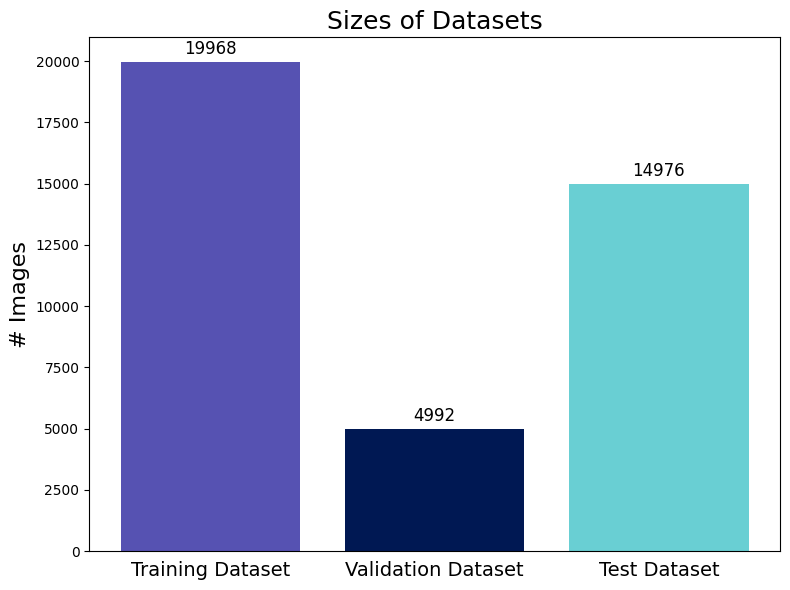

In [10]:
# Calculate the total number of images in each dataset
train_images = train_dataset.cardinality().numpy() * batch_size
validation_images = validation_dataset.cardinality().numpy() * batch_size
test_images = test_dataset.cardinality().numpy() * batch_size

# Set the labels and values for the bars
labels = ['Training Dataset', 'Validation Dataset', 'Test Dataset']
values = [train_images, validation_images, test_images]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart
b = ax.bar(labels, values, color=['#5652b2', '#001853', '#69cfd3'])

# Customize the plot
ax.set_ylabel('# Images', fontsize=16)
ax.set_title('Sizes of Datasets', fontsize=18)
ax.tick_params(bottom=False, left=True)
# Increase the font size of x-axis tick labels
ax.tick_params(axis='x', labelsize=14)

# Add text labels on top of the bars
for rect in b:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

#### Anzahl der Bilder pro Klasse

['end_speed', 'no_sign', 'no_speed_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']


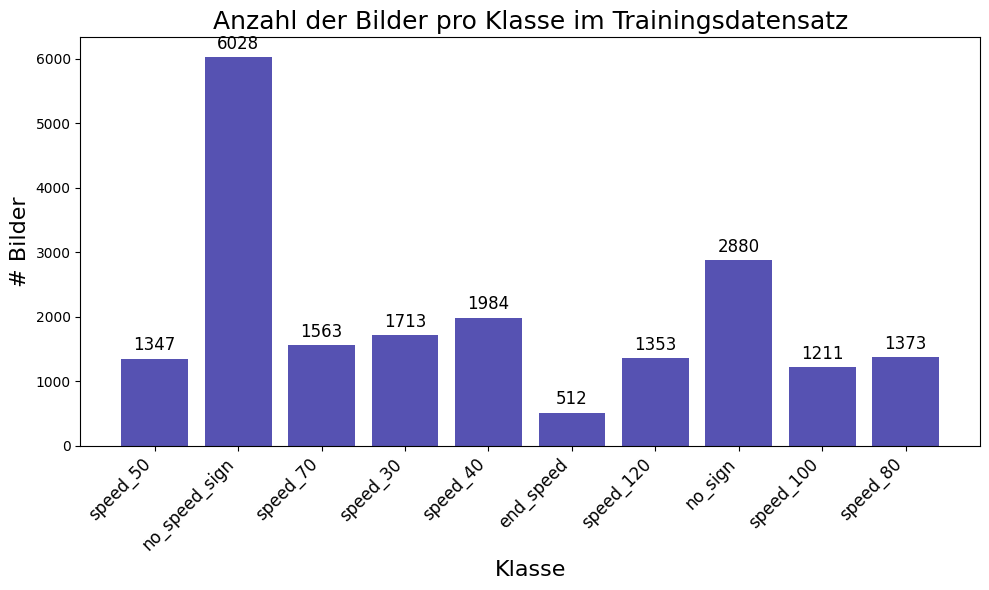

In [11]:
plot_class_names = train_dataset.class_names
print(class_names)

# Anzahl der Bilder pro Klasse im Trainingsdatensatz
class_counts = {}
for images, labels in train_dataset:
    for label in labels.numpy():
        class_idx = tf.argmax(label).numpy()
        class_name = train_dataset.class_names[class_idx]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

# Diagramm für die Anzahl der Bilder pro Klasse
fig, ax = plt.subplots(figsize=(10, 6))

# Extrahieren der Klassen und zugehörigen Anzahlen
classes, counts = zip(*class_counts.items())
plot_class_names = list(classes)

b = ax.bar(plot_class_names, counts, color='#5652b2')

# Customize the plot
ax.set_xlabel('Klasse', fontsize=16)
ax.set_ylabel('# Bilder', fontsize=16)
ax.set_title('Anzahl der Bilder pro Klasse im Trainingsdatensatz', fontsize=18)
ax.tick_params(bottom=True, left=True)
ax.set_xticks(class_names)
ax.set_xticklabels(class_names, fontsize=12, rotation=45, ha="right")

# Add text labels on top of the bars
for rect in b:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

##### Plot some of the images:

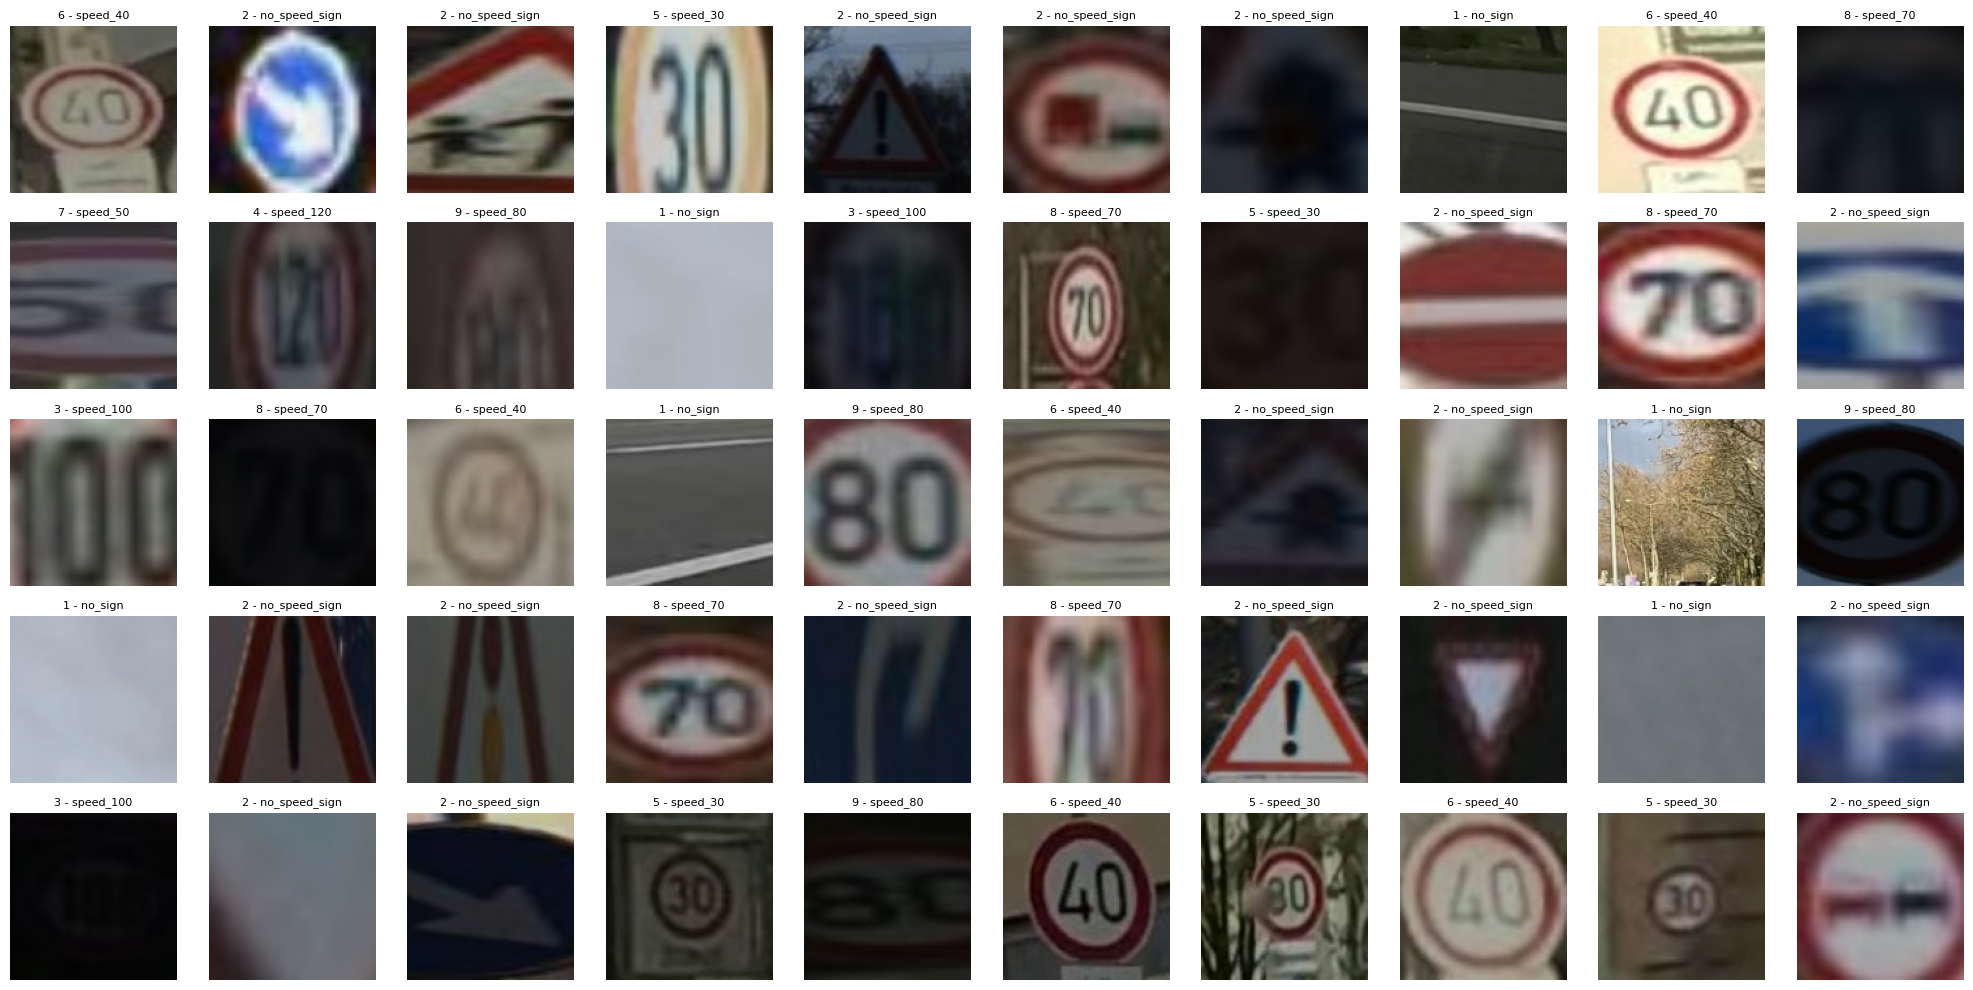

In [12]:
# Anzahl der Bilder, die Sie anzeigen möchten
num_images = 50

# Berechnen der Anzahl von Reihen und Spalten
num_rows = 5
num_cols = 10

plt.figure(figsize=(2 * num_cols, 2 * num_rows))
for images, labels in train_dataset.take(1):
    for i in range(num_images):
        if i >= len(images):
            break  # Verhindert einen Index-Fehler, falls weniger Bilder als num_images vorhanden sind
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy()) if isinstance(labels[i], tf.Tensor) else np.argmax(labels[i])
        plt.title(str(label_index) + ' - ' + train_dataset.class_names[label_index], fontsize=8)
        plt.axis("off")
plt.tight_layout()
plt.show()

Enable prefetching for faster batch processing

In [24]:
AUTOTUNE = tf.data.AUTOTUNE


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Create own model

In [44]:
input_shape = (desired_height, desired_width, input_channels)

own_model_shallow = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescaling-Schicht hinzufügen
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')  # Use softmax for multi-class classification
])

In [47]:
# create callbacks by calling the previously defined functions
post_string = ""
if input_channels == 1:
    post_string = "_gray"

checkpoint_callback = create_checkpoint('own_model_shallow'+ post_string)
earlystopping_callback = create_early_stopping(10)

#### Compile and train model

In [48]:
own_model_shallow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']
)

In [49]:
# Record the start time
start_time = time.time()

history_own_model_shallow = own_model_shallow.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=100,
  callbacks=[
    checkpoint_callback,
    earlystopping_callback
    ],

  class_weight = {i: 1.0 for i in range(number_of_classes)}
)

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100


1225/1225 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.7135
Epoch 1: val_accuracy improved from -inf to 0.89191, saving model to models\own_model_shallow_gray.h5
1225/1225 [==============================] - 34s 24ms/step - loss: 0.9159 - accuracy: 0.7135 - val_loss: 0.3657 - val_accuracy: 0.8919
Epoch 2/100
1222/1225 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.9162
Epoch 2: val_accuracy improved from 0.89191 to 0.91722, saving model to models\own_model_shallow_gray.h5
1225/1225 [==============================] - 25s 21ms/step - loss: 0.2843 - accuracy: 0.9163 - val_loss: 0.2869 - val_accuracy: 0.9172
Epoch 3/100
 335/1225 [=======>......................] - ETA: 15s - loss: 0.2042 - accuracy: 0.9387

KeyboardInterrupt: 

##### Evaluate

Training time until best accuracy: 215.9980 seconds and 15 epochs
90/90 [==============================] - 1s 9ms/step - loss: 0.1120 - accuracy: 0.9816


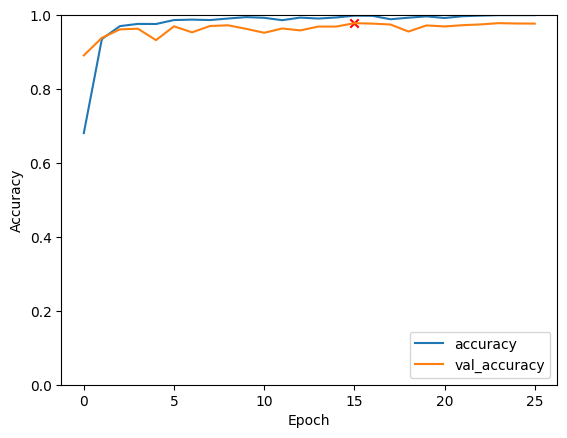

In [53]:
evaluate_model(history_own_model_shallow, own_model_shallow, 'own_model_shallow', training_time, test_dataset)

### Create a deeper model with more layers

In [15]:
desired_height, desired_width = 128, 128
input_shape = (desired_height, desired_width)

own_model_deeper = tf.keras.Sequential([
    tf.keras.layers.Resizing(desired_height, desired_width),  # Resizing layer
    tf.keras.layers.Rescaling(1./255),  # Rescaling-Schicht hinzufügen
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape, data_format='channels_last'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')  # Change to softmax for multi-class classification
])


ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [55]:
# create callbacks by calling the previously defined functions
post_string = ""
if input_channels == 1:
    post_string = "_gray"

checkpoint_callback = create_checkpoint('own_model_deeper'+post_string)
earlystopping_callback = create_early_stopping(20)

own_model_deeper.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])
own_model_deeper.summary()

  # Record the start time
start_time = time.time()

history_own_model_deeper = own_model_deeper.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=100,
  callbacks=[
    checkpoint_callback,
    earlystopping_callback
  ],
  class_weight = {i: 1.0 for i in range(number_of_classes)}
)

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100


409/409 [==============================] - ETA: 0s - loss: 1.7670 - accuracy: 0.5281
Epoch 1: val_accuracy improved from -inf to 0.43723, saving model to models\own_model_deeper.h5
409/409 [==============================] - 8s 18ms/step - loss: 1.7670 - accuracy: 0.5281 - val_loss: 3.1982 - val_accuracy: 0.4372
Epoch 2/100
405/409 [============================>.] - ETA: 0s - loss: 0.8711 - accuracy: 0.6941
Epoch 2: val_accuracy improved from 0.43723 to 0.82119, saving model to models\own_model_deeper.h5
409/409 [==============================] - 7s 18ms/step - loss: 0.8687 - accuracy: 0.6949 - val_loss: 0.5418 - val_accuracy: 0.8212
Epoch 3/100
408/409 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.7730
Epoch 3: val_accuracy improved from 0.82119 to 0.89008, saving model to models\own_model_deeper.h5
409/409 [==============================] - 7s 18ms/step - loss: 0.6546 - accuracy: 0.7728 - val_loss: 0.3348 - val_accuracy: 0.8901
Epoch 4/100
407/409 [==========

Training time until best accuracy: 702.8636 seconds and 78 epochs
90/90 [==============================] - 1s 9ms/step - loss: 0.0741 - accuracy: 0.9927


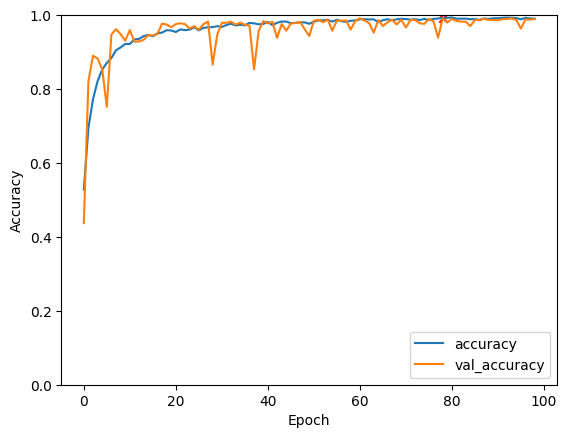

In [56]:
evaluate_model(history_own_model_deeper, own_model_deeper, 'own_model_deeper', training_time, test_dataset)

#### Use a pre-trained network - Transfer Learning

In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (desired_width, desired_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation="softmax",
                                               classes=len(class_names))


Preprocessing layer:

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Freeze or unfreeze the convolutional base

In [27]:
base_model.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

Add the classification head for sign classification

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# convert features to single 1280 element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(number_of_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(64, 4, 4, 1280)
(64, 1280)
(64, 10)


Build the model:
* add a resizing layer as the Network was trained on images with the size of 160x160

In [29]:
inputs = tf.keras.Input(shape=(128, 128, input_channels))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

There are 158 layers trainable


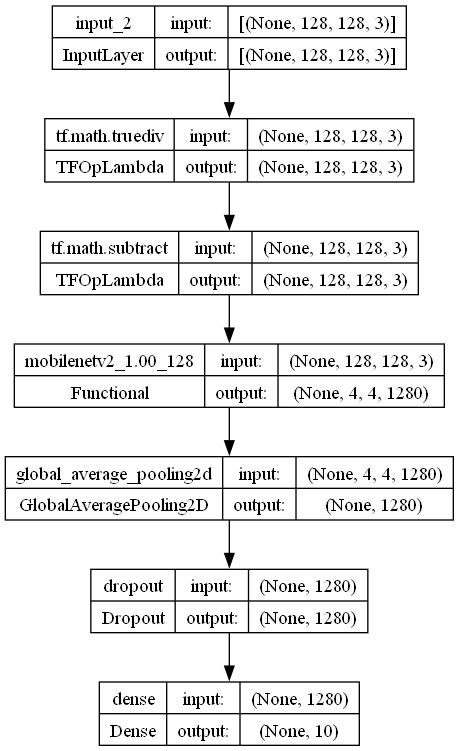

In [30]:
print(f"There are {len(model.trainable_variables)} layers trainable")
tf.keras.utils.plot_model(model, show_shapes=True)

Compile the model:

In [31]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


First evaluate the model:

In [32]:
loss0, accuracy0 = model.evaluate(validation_dataset)
1
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


156/156 [==============================] - 9s 45ms/step - loss: 2.9395 - accuracy: 0.0509
initial loss: 2.94
initial accuracy: 0.05


The accuracy is expected. As there are 9 categories, the model just guesses one of them which is about 10-12% correct.

Now finetuning is done:

In [33]:
# create callbacks by calling the previously defined functions
post_string = ""
if input_channels == 1:
    post_string = "_gray"

checkpoint_callback = create_checkpoint('MobileNet'+post_string)
earlystopping_callback = create_early_stopping(10)

# Record the start time
start_time = time.time()

history_mobilenet = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback],
                    class_weight = {i: 1.0 for i in range(number_of_classes)}
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/200
624/624 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.8309
Epoch 1: val_accuracy improved from -inf to 0.94981, saving model to models\MobileNet.h5
624/624 [==============================] - 63s 94ms/step - loss: 0.5088 - accuracy: 0.8309 - val_loss: 0.1556 - val_accuracy: 0.9498
Epoch 2/200
624/624 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9575
Epoch 2: val_accuracy improved from 0.94981 to 0.96494, saving model to models\MobileNet.h5
624/624 [==============================] - 58s 93ms/step - loss: 0.1293 - accuracy: 0.9575 - val_loss: 0.1066 - val_accuracy: 0.9649
Epoch 3/200
624/624 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9756
Epoch 3: val_accuracy improved from 0.96494 to 0.97225, saving model to models\MobileNet.h5
624/624 [==============================] - 58s 93ms/step - loss: 0.0743 - accuracy: 0.9756 - val_loss: 0.0971 - val_accuracy: 0.9723
Epoch 4/200
624/624 [================

### Load the saved models from disc if desired to make predictions

Training time until best accuracy: 1508.2619 seconds and 15 epochs
156/156 [==============================] - 5s 25ms/step - loss: 0.0562 - accuracy: 0.9859


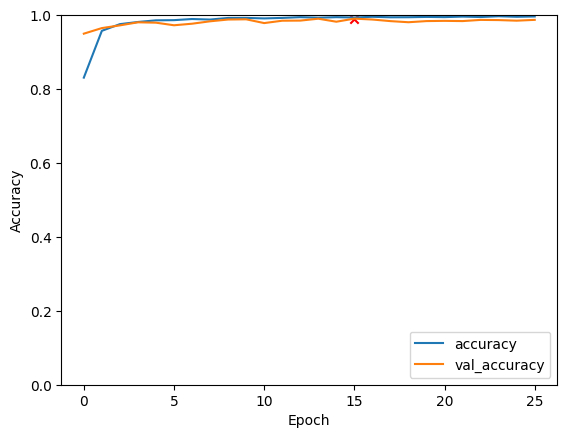

In [34]:
evaluate_model(history_mobilenet, model, 'MobileNet', training_time, test_dataset)

In [35]:
models =  {
    'own_model_shallow', 'own_model_deeper', 'MobileNet'
}


load_from_disc = True
own_model_shallow = None
own_model_deeper = None

if load_from_disc:
    model_path_shallow = os.path.join("models/", 'own_model_shallow.h5')
    model_path_deep = os.path.join("models/", 'own_model_deeper.h5')
    model_path_mobileNet = os.path.join("models/", 'MobileNetAugmented.h5')
    own_model_shallow = tf.keras.models.load_model(model_path_shallow)
    own_model_deeper = tf.keras.models.load_model(model_path_deep)
    own_model_mobileNetAugmented = tf.keras.models.load_model(model_path_mobileNet)


#### Measure the time required for one prediction

3/3 [==============================] - 0s 121ms/step
Average prediction time: 0.0010 seconds
Average probability of misclassified images: 0.5676


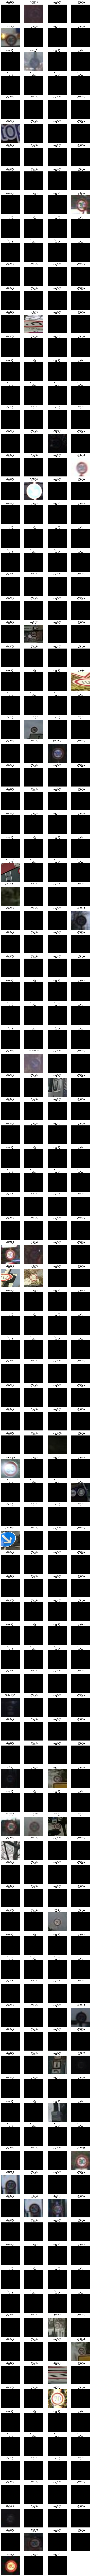

In [36]:
plot_misclassified_images_with_filenames(own_model_mobileNetAugmented, 100)

1/1 [==============================] - 0s 25ms/step
required time: 0.059000253677368164
['end_speed', 'no_sign', 'no_speed_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
[[8.9837022e-06 1.2140386e-05 9.4176867e-06 1.3392765e-05 6.8219546e-05
  9.6849102e-01 1.3477232e-06 3.1059790e-02 7.6074357e-05 2.5951871e-04]]


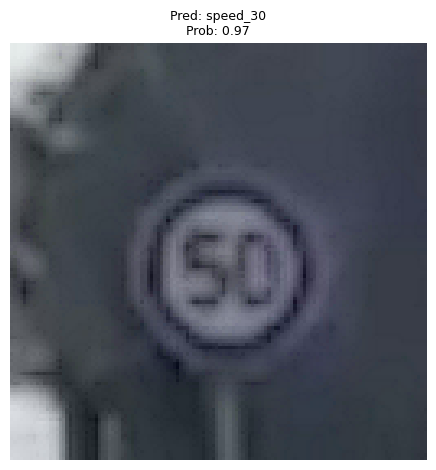

In [29]:
image_path = r'C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\test_video_results_augmented_mobile\tests\GX010096\rois\speed_30\speed_30_4.jpg'
class_names = ['end_speed', 'no_sign', 'no_speed_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
# Load the image
image = cv2.imread(image_path)

# Anwenden des Laplace-Filters für Kantenverstärkung
laplacian = cv2.Laplacian(image, cv2.CV_64F)

# Umwandlung des Laplace-Ergebnisses in denselben Datentyp wie das Originalbild
laplacian = np.uint8(np.absolute(laplacian))

# Kombinieren des Originalbildes mit dem Laplace-Ergebnis
sharp_image = cv2.subtract(image, laplacian)

sharp_image_rgb = cv2.cvtColor(sharp_image, cv2.COLOR_BGR2RGB)

# Anzeigen und Speichern des Bildes (optional)
cv2.imshow("Sharp Image", sharp_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Add batch dimension to match the expected input shape (1, 128, 128, 1)
input_data = np.expand_dims(sharp_image, axis=0)

start_time = time.time()
pred_probs = own_model_mobileNetAugmented.predict(input_data)
end_time = time.time()
print(f"required time: {end_time-start_time}")

print(class_names)
print(pred_probs)
pred_label = np.argmax(pred_probs)

# Plotten der falsch klassifizierten Bilder

plt.imshow(sharp_image)
plt.title(f"Pred: {class_names[pred_label]}\nProb: {np.max(pred_probs):.2f}", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()

## Networks with Data Augmentation

Training the network with augmented data (3x data samples)

Load the augmented datasets

In [26]:
batch_size = 32

# Laden der Bilder und Labels aus den Unterordnern
print("Training dataset:")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_images_data_folder,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nValidation dataset:")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=augmented_images_data_folder,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nTest dataset:")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_folder,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)
'''do something nice'''

Training dataset:
Found 48989 files belonging to 10 classes.
Using 39192 files for training.

Validation dataset:
Found 48989 files belonging to 10 classes.
Using 9797 files for validation.

Test dataset:


NotFoundError: Could not find directory C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision_repo\datasets\sign_classification\test

In [93]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (desired_width, desired_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# preprocessing and unfreezing of the base layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model.trainable = True
base_model.summary()

# add classification head:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# convert features to single 1280 element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(number_of_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

Create the model

In [94]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [95]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


# create callbacks by calling the previously defined functions
checkpoint_callback = create_checkpoint('MobileNetAugmented')
earlystopping_callback = create_early_stopping(10)

# Record the start time
start_time = time.time()

history_mobilenet_aug = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback]
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100
678/678 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8424
Epoch 1: val_accuracy improved from -inf to 0.94246, saving model to models\MobileNetAugmented.h5
678/678 [==============================] - 39s 52ms/step - loss: 0.4306 - accuracy: 0.8424 - val_loss: 0.1685 - val_accuracy: 0.9425
Epoch 2/100
677/678 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9704
Epoch 2: val_accuracy improved from 0.94246 to 0.98525, saving model to models\MobileNetAugmented.h5
678/678 [==============================] - 33s 49ms/step - loss: 0.0892 - accuracy: 0.9704 - val_loss: 0.0452 - val_accuracy: 0.9852
Epoch 3/100
678/678 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9826
Epoch 3: val_accuracy improved from 0.98525 to 0.98727, saving model to models\MobileNetAugmented.h5
678/678 [==============================] - 33s 49ms/step - loss: 0.0522 - accuracy: 0.9826 - val_loss: 0.0358 - val_accuracy: 0.9873
Epoch 4/10

In [84]:
evaluate_model(history_mobilenet_aug, model, 'MobileNetAugmented', training_time, test_dataset)

plot_misclassified_images_with_filenames(model, 100)

NameError: name 'history_mobilenet_aug' is not defined